<a href="https://colab.research.google.com/github/imelda18/quizapp/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"imeldd","key":"7fbce2dfe18b7ad84106ec95c831721b"}'}

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:22<00:00, 193MB/s]
100% 2.29G/2.29G [00:22<00:00, 108MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:

# Check the folder structure
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

print("Train data:", os.listdir(train_dir))
print("Validation data:", os.listdir(val_dir))
print("Test data:", os.listdir(test_dir))


Train data: ['PNEUMONIA', 'NORMAL']
Validation data: ['PNEUMONIA', 'NORMAL']
Test data: ['PNEUMONIA', 'NORMAL']


In [ ]:
print("Train samples:", len(os.listdir(train_dir + '/PNEUMONIA')) + len(os.listdir(train_dir + '/NORMAL')))
print("Validation samples:", len(os.listdir(val_dir + '/PNEUMONIA')) + len(os.listdir(val_dir + '/NORMAL')))
print("Test samples:", len(os.listdir(test_dir + '/PNEUMONIA')) + len(os.listdir(test_dir + '/NORMAL')))

Train samples: 5216
Validation samples: 16
Test samples: 624


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set up directories
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA')
train_normal = os.path.join(train_dir, 'NORMAL')

# Create a validation set by splitting the data
def create_validation_set():
    # List all the files in the pneumonia and normal directories
    pneumonia_files = os.listdir(train_pneumonia)
    normal_files = os.listdir(train_normal)

    # Split the files into training and validation sets
    pneumonia_train, pneumonia_val = train_test_split(pneumonia_files, test_size=0.2, random_state=42)
    normal_train, normal_val = train_test_split(normal_files, test_size=0.2, random_state=42)

    # Create the validation directories
    val_pneumonia = os.path.join(val_dir, 'PNEUMONIA')
    val_normal = os.path.join(val_dir, 'NORMAL')
    os.makedirs(val_pneumonia, exist_ok=True)
    os.makedirs(val_normal, exist_ok=True)

    # Move the validation files
    for file in pneumonia_val:
        shutil.move(os.path.join(train_pneumonia, file), os.path.join(val_pneumonia, file))
    for file in normal_val:
        shutil.move(os.path.join(train_normal, file), os.path.join(val_normal, file))

# Create validation set
create_validation_set()

In [ ]:
print("Train samples:", len(os.listdir(train_dir + '/PNEUMONIA')) + len(os.listdir(train_dir + '/NORMAL')))
print("Validation samples:", len(os.listdir(val_dir + '/PNEUMONIA')) + len(os.listdir(val_dir + '/NORMAL')))
print("Test samples:", len(os.listdir(test_dir + '/PNEUMONIA')) + len(os.listdir(test_dir + '/NORMAL')))

Train samples: 4172
Validation samples: 1060
Test samples: 624


In [ ]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for the validation and test sets (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the flow from directory for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,  # Increased batch size
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,  # Increased batch size
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,  # Increased batch size
    class_mode='binary'
)


Found 4172 images belonging to 2 classes.
Found 1060 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
# Load the MobileNetV2 model with pre-trained weights, excluding the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers of the base model
base_model.trainable = True

# Freeze earlier layers to retain pre-trained features
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)


In [24]:
# Retrain the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Fewer epochs for fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.9205 - loss: 0.1954 - val_accuracy: 0.8711 - val_loss: 0.2950 - learning_rate: 1.0000e-05
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9688 - loss: 0.1314 - val_accuracy: 0.8889 - val_loss: 0.2542 - learning_rate: 1.0000e-05
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 385s 5s/step - accuracy: 0.9401 - loss: 0.1410 - val_accuracy: 0.8936 - val_loss: 0.2506 - learning_rate: 1.0000e-05
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 392ms/step - accuracy: 0.9531 - loss: 0.1089 - val_accuracy: 0.8889 - val_loss: 0.1659 - learning_rate: 1.0000e-05
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 353s 5s/step - accuracy: 0.9395 - loss: 0.1470 - val_accuracy: 0.8936 - val_loss: 0.2505 - learning_rate: 1.0000e-05
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9219 - loss: 0.2063 - val_accuracy: 0.9722 - val_loss: 0.0817 - learning_rate: 1.0000e-05
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - accuracy: 0.939

In [25]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8832 - loss: 0.2606
Test accuracy: 0.8889


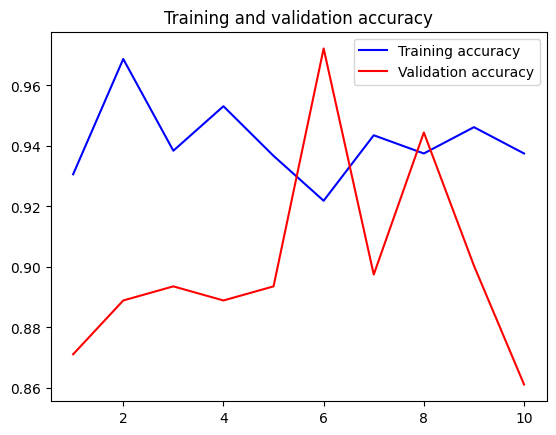

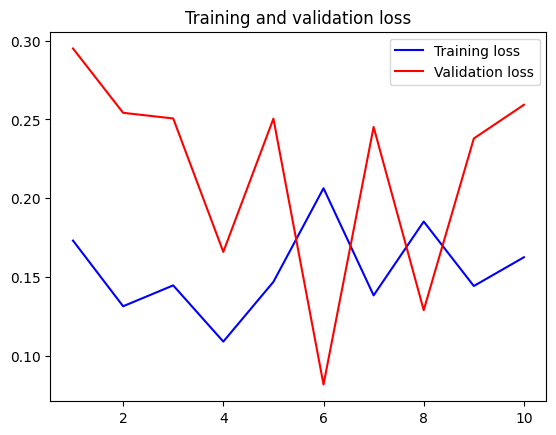

In [31]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Loss plot
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
# Save the trained model
model.save('pneumonia_detection_model.h5')


In [27]:
model.save('pneumonia_detection_model.keras')

In [28]:
# Example: Predicting on a new image
from tensorflow.keras.preprocessing import image

img_path = '/content/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg'  # Replace with the image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

prediction = model.predict(img_array)
if prediction[0] > 0.5:
    print("Pneumonia detected")
else:
    print("No Pneumonia detected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Pneumonia detected


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


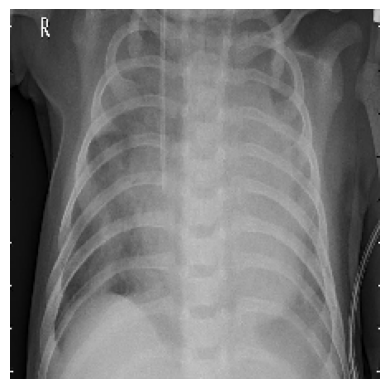

Pneumonia detected


In [30]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image you want to predict
img_path = '/content/chest_xray/test/PNEUMONIA/person100_bacteria_480.jpeg'  # Replace with the image path

# Load the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make the prediction
prediction = model.predict(img_array)


# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Print the prediction result
if prediction[0] > 0.5:
    print("Pneumonia detected")
else:
    print("No Pneumonia detected")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


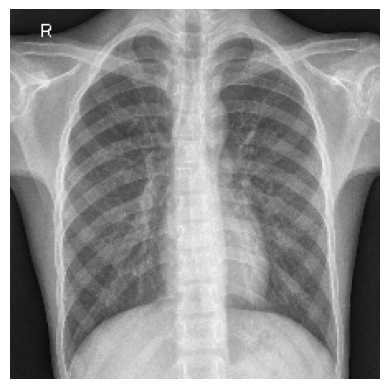

No Pneumonia detected


In [32]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image you want to predict
img_path = '/content/chest_xray/test/NORMAL/IM-0005-0001.jpeg'  # Replace with the image path

# Load the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make the prediction
prediction = model.predict(img_array)


# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

# Print the prediction result
if prediction[0] > 0.5:
    print("Pneumonia detected")
else:
    print("No Pneumonia detected")